In [29]:
import sys
sys.path.append("../src")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from exact_solution import solve_master_equation, one_excited_emitter_state

In [30]:
aqt_results = pd.read_csv("../data/AQT/QMarina-AQT-4Q.csv", index_col=0)
aqt_results = aqt_results.set_index(["Time", "Protocol", "Randomizations", "Identities"])

aqt_raw = aqt_results.xs("RAW", level="Protocol")
aqt_times = aqt_raw.index.get_level_values("Time").unique()

# renormalize in the 1-excitation subspace; average emitter 2 and 3
raw_data_norm = aqt_raw.copy()
raw_data_norm[['1000', '0100', '0010', '0001']] = raw_data_norm[['1000', '0100', '0010', '0001']].divide(raw_data_norm[['1000', '0100', '0010', '0001']].sum(axis=1), axis=0)
raw_data_norm['avg_0100_0001'] = raw_data_norm[['0100', '0001']].mean(axis=1)


### NOX data

nox_data = aqt_results.xs("NOX", level="Protocol")
aqt_times = nox_data.index.get_level_values("Time").unique()

# renormalize in the 1-excitation subspace; average emitter 2 and 3
nox_data_norm = nox_data.copy()
nox_data_norm[['1000', '0100', '0010', '0001']] = nox_data_norm[['1000', '0100', '0010', '0001']].divide(nox_data_norm[['1000', '0100', '0010', '0001']].sum(axis=1), axis=0)
nox_data_norm['avg_0100_0001'] = nox_data_norm[['0100', '0001']].mean(axis=1)

In [31]:
N = 3
g = 4
kappa = 2
times = np.linspace(0, 3, 51)

In [32]:
initial_state = one_excited_emitter_state(N, 1)
qutip_results = solve_master_equation(N, g, kappa, initial_state, times)

/var/folders/ds/t6zgkw3n75d3gzz89xmkcncm0000gn/T/ipykernel_66604/186057380.py:92: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


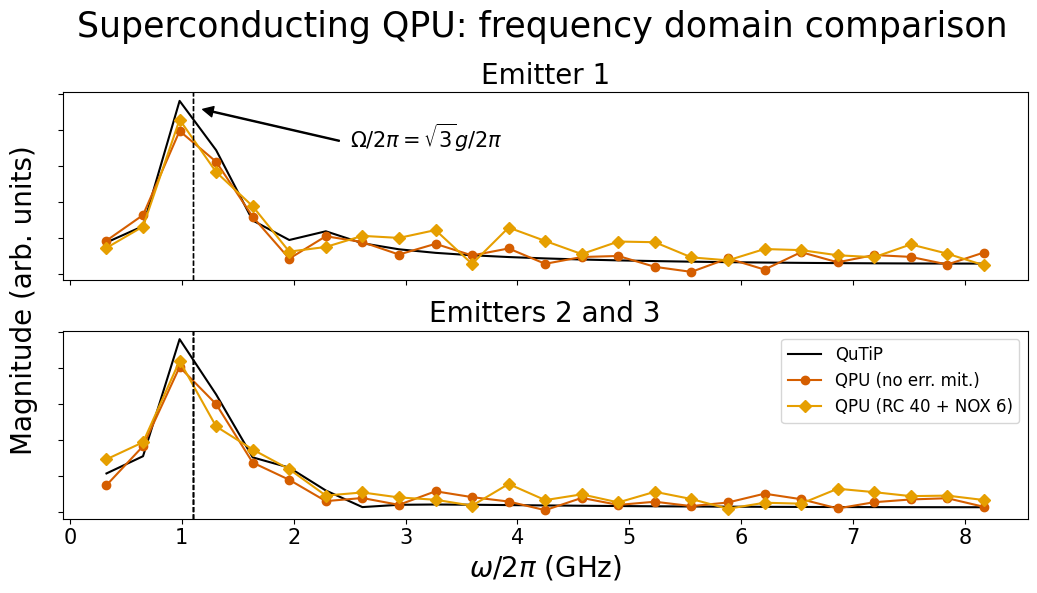

In [33]:
raw_data = aqt_results.xs("RAW", level="Protocol")
n = len(raw_data)
rabi_freq = np.sqrt(3) * g / (2*np.pi)

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

##### No Error Mit.

## Emitter 1
fft = np.fft.rfft(qutip_results["Emitter 1"], n)
freqs = np.fft.rfftfreq(n, times[1] - times[0])
axes[0].plot(freqs[1:], np.abs(fft)[1:], label="QuTiP", color='black')

fft = np.fft.rfft(raw_data_norm["1000"], n)
freqs = np.fft.rfftfreq(n, times[1] - times[0])
axes[0].plot(freqs[1:], np.abs(fft)[1:], label="QPU (no err. mit.)",  marker='o', color='#d55e00')

axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].set_title("Emitter 1", fontsize=20)

axes[0].axvline(rabi_freq, lw=1, color='black', linestyle='--')


## Emitter 2 & 3
fft = np.fft.rfft(qutip_results["Emitter 2"], n)
freqs = np.fft.rfftfreq(n, times[1] - times[0])
axes[1].plot(freqs[1:], np.abs(fft)[1:], label="QuTiP", color='black')

fft = np.fft.rfft(raw_data_norm["avg_0100_0001"], n)
freqs = np.fft.rfftfreq(n, times[1] - times[0])
axes[1].plot(freqs[1:], np.abs(fft)[1:], label="QPU (no err. mit.)", marker='o', color='#d55e00')

axes[1].tick_params(axis='x', labelsize=15)
axes[1].set_yticklabels([])
axes[1].set_title("Emitters 2 and 3", fontsize=20)
axes[1].axvline(rabi_freq, lw=1, color='black', linestyle='--')
axes[1].set_xlabel(r"$\omega / 2\pi$ (GHz)", fontsize=20)

axes[1].axvline(rabi_freq, lw=1, color='black', linestyle='--')


##### RC 40 + NOX 6

## Emitter 1
fft = np.fft.rfft(nox_data_norm["1000"], n)
freqs = np.fft.rfftfreq(n, times[1] - times[0])
axes[0].plot(freqs[1:], np.abs(fft)[1:], label="QPU (RC 40 + NOX 6)",  marker='D', color='#e69f00')

axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].set_title("Emitter 1", fontsize=20)

axes[0].axvline(rabi_freq, lw=1, color='black', linestyle='--')


## Emitter 2 & 3
fft = np.fft.rfft(nox_data_norm["avg_0100_0001"], n)
freqs = np.fft.rfftfreq(n, times[1] - times[0])
axes[1].plot(freqs[1:], np.abs(fft)[1:], label="QPU (RC 40 + NOX 6)", marker='D', color='#e69f00')

axes[1].tick_params(axis='x', labelsize=15)
axes[1].set_yticklabels([])
axes[1].set_title("Emitters 2 and 3", fontsize=20)
axes[1].axvline(rabi_freq, lw=1, color='black', linestyle='--')
axes[1].set_xlabel(r"$\omega / 2\pi$ (GHz)", fontsize=20)

axes[1].axvline(rabi_freq, lw=1, color='black', linestyle='--')
axes[1].legend(fontsize=12)


##### Fig level additions

fig.text(-0.04, 0.72, "Magnitude (arb. units)", transform=axes[0].transAxes,
        ha='center', va='top', fontsize=20, rotation=90)

axes[0].annotate(
    r'$\Omega/2\pi = \sqrt{3}g/2\pi$', # the text of the annotation
    fontsize=15,
    xy=(rabi_freq + 0.06, 4.6),       # the point (x,y) to annotate
    xytext=(2.5, 3.5),   # the position of the text (x,y)
    arrowprops=dict(
        arrowstyle="simple, tail_width=0.05, head_width=.5, head_length=.5",
        connectionstyle="arc3",  # connection style
        facecolor='black',
        relpos=(-0.05, 0.4),
    )
)

fig.suptitle("Superconducting QPU: frequency domain comparison", fontsize=25)
plt.tight_layout()
fig.show()

In [34]:
fig.savefig("../figures/AQT_fourier.eps", bbox_inches="tight")